In [1]:
# Standard imports
import pandas as pd
import sys 
import os
import seaborn as sns
import os
import shutil
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt
# Local imports
sys.path.insert(1, os.path.join(sys.path[0], '..'))


In [2]:
collider = xt.Multiline.from_json("/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/opt_collapse_1000_1500_thin_collider/base_collider/xtrack_0000/collider.json")
collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


In [3]:
def get_amplitude_detuning(line, nemitt_x=1.e-6, nemitt_y=1.e-6, num_turns=100, zeropad=100000):
    '''
    returns axx, axy, ayx, ayy that correspond to the first order amplitude-detuning,
    estimated through tracking.
    The relations between tune (Q) and action (J) in this case is:
    $$ Q_x = Q_{x,0} + axx * Jx + axy * Jy $$
    $$ Q_y = Q_{y,0} + ayx * Jx + ayy * Jy $$
    '''

    egeom_x = nemitt_x / line.particle_ref.gamma0
    egeom_y = nemitt_y / line.particle_ref.gamma0

    frequency = np.fft.fftfreq(zeropad)

    sigma = 6
    num_r = 100
    JJ = np.linspace(0.01, sigma, num_r)
    A_norm = np.sqrt(2*JJ).flatten()
    other_norm = 0.01

    particles = line.build_particles(x_norm=A_norm, y_norm=other_norm,
                                     nemitt_x=nemitt_x, nemitt_y=nemitt_y)

    line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
    # line.tracker._context.synchronize()

    x = line.record_last_track.x
    y =  line.record_last_track.y

    qx = [abs(frequency[np.argmax(np.abs(np.fft.fft(x[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    qy = [abs(frequency[np.argmax(np.abs(np.fft.fft(y[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    # qx = NAFFlib.multiparticle_tunes(x)
    # qy = NAFFlib.multiparticle_tunes(y)

    axx = np.polyfit(JJ*egeom_x, qx, 1)[0]
    ayx = np.polyfit(JJ*egeom_x, qy, 1)[0]

    # switch x and y
    particles = line.build_particles(x_norm=other_norm, y_norm=A_norm,
                                     nemitt_x=nemitt_x, nemitt_y=nemitt_y)

    line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
    # line.tracker._context.synchronize()

    x = line.record_last_track.x
    y = line.record_last_track.y

    qx = [abs(frequency[np.argmax(np.abs(np.fft.fft(x[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    qy = [abs(frequency[np.argmax(np.abs(np.fft.fft(y[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    # qx = NAFFlib.multiparticle_tunes(x)
    # qy = NAFFlib.multiparticle_tunes(y)

    axy = np.polyfit(JJ*egeom_y, qx, 1)[0]
    ayy = np.polyfit(JJ*egeom_y, qy, 1)[0]

    return axx, axy, ayx, ayy

In [4]:
axx, axy, ayx, ayy = get_amplitude_detuning(collider.lhcb1)

print(f"axx = {1.e-6*axx:.3f} um^-1")
print(f"axy = {1.e-6*axy:.3f} um^-1")
print(f"ayx = {1.e-6*ayx:.3f} um^-1")
print(f"ayy = {1.e-6*ayy:.3f} um^-1")

axx = 4.843 um^-1
axy = 8.730 um^-1
ayx = 27.162 um^-1
ayy = 4.756 um^-1


In [5]:
#def get_analytical_detuning(line):

# get octupolar and quadrupolar strengths
d_oct = {}
d_quad = {}
for element,name in zip(collider.lhcb1.elements, collider.lhcb1.element_names):
    #if 'mo.' in name:
    #    print(name, element.to_dict())
    if '_order' in element.to_dict():
        if element.to_dict()['_order'] >= 3:
            if element.to_dict()['knl'][3]!=0:
                d_oct[name] = {'knl' : element.to_dict()['knl'][3]}
                if element.to_dict()['ksl'][3]!=0:
                    print('CAUTION, ksl is not zero for element', name)
        elif element.to_dict()['_order'] >= 1:
            if element.to_dict()['knl'][1]!=0:
                d_quad[name] = {'knl' : element.to_dict()['knl'][1]}
                if element.to_dict()['ksl'][1]!=0:
                    print('CAUTION, ksl is not zero for element', name)
            
                    
# Get corresponding beta functions
tw = collider.lhcb1.twiss(method="6d", matrix_stability_tol=100)
octupoles = tw[['s', 'betx', 'bety'], 'mo.*']
quadrupoles = tw[['s', 'betx', 'bety'], 'mq.*']

for line in octupoles.rows:
    name = str(line.name.squeeze())
    if name in d_oct:
        d_oct[name]['betx'] = line.betx
        d_oct[name]['bety'] = line.bety
        
for line in quadrupoles.rows:
    name = str(line.name.squeeze())
    if name in d_quad:
        d_quad[name]['betx'] = line.betx
        d_quad[name]['bety'] = line.bety

In [6]:
# Get analytical octupolar detuning
array_Jx = np.linspace(0.01, 6, 100)
array_Jy = np.linspace(0.01, 6, 100)
array_dqx_oct = 1 / (2 * np.pi) * 0.75 * np.sum( [ d_oct[name]["knl"] * (d_oct[name]["betx"] ** 2 * array_Jx - 2 * d_oct[name]["betx"] * d_oct[name]["bety"]*array_Jy) for name in d_oct ], axis = 0 ) 
array_dqy_oct = 1 / (2 * np.pi) * (-0.75) * np.sum( [ d_oct[name]["knl"] * (2 * d_oct[name]["betx"] * d_oct[name]["bety"]*array_Jx - d_oct[name]["bety"] ** 2 * array_Jy) for name in d_oct ], axis = 0 ) 
array_dqx_quad = 1 / (2 * np.pi) * 0.5 * np.sum( [ d_quad[name]["knl"] * d_quad[name]["betx"] * array_Jx for name in d_quad ], axis = 0 ) 
array_dqy_quad = 1 / (2 * np.pi) * (-0.5) * np.sum( [ d_quad[name]["knl"] * d_quad[name]["bety"] * array_Jy for name in d_quad ], axis = 0 ) 
array_dqx = array_dqx_oct + array_dqx_quad
array_dqy = array_dqy_oct + array_dqy_quad

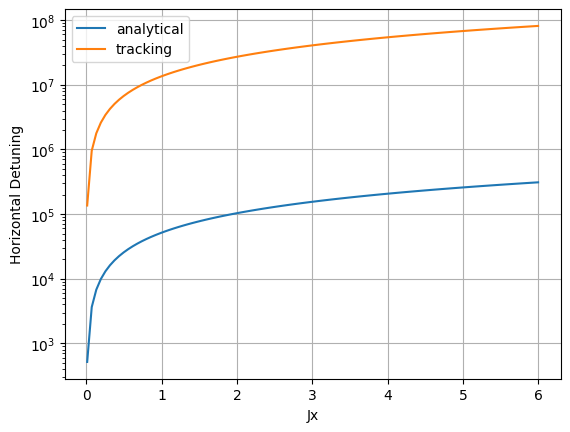

In [7]:
plt.plot(array_Jx,array_dqx, label="analytical")
plt.plot(array_Jx, axx * array_Jx + axy * array_Jy, label="tracking")
plt.yscale("log")
plt.legend()
plt.xlabel("Jx")
plt.ylabel("Horizontal Detuning")
plt.grid()
plt.show()

In [12]:
ratio = array_dqx/(axx * array_Jx + axy * array_Jy)
print(np.std(ratio))
print(np.mean(ratio))

1.3911627867341097e-18
0.0038066856124874156
